# Main goals of this notebook

This notebook shows the baseline for document classification using topic definitions. The approach is the simple Train / Test method for training a classification algorithm, with the important caveat that it is a "one shot" task: only learns on a single example of each class, and gets evaluated over a big portion of test examples.

This notebook makes use of a self-made code library that allows the following:
* Dataset creation based on a wikipedia parser tool
* Raw text cleaning
* Text processing to make it suitable for classification algorithms input expectations.

This library can be found here: [GitHub/OneShotDocClassifier](https://github.com/andresC98/One-Shot-DocClassifier)

**Important note:** Purpose of this notebook is an initial check of baseline. THIS USED AN OLD VERSION OF LIBRARY MODULES. Please check last notebook for an updated usage of the library.

# Libraries

In [0]:
#3rd party libraries installation for colaboratory
!pip install wikipedia
!pip install Wikipedia-API

In [2]:
#OUTDATED LIBRARY, This notebook is for mainly check baseline results. Updated version of library is at last notebook.
#Importing my library
#IMPORTANT NOTE: It is needed to upload "doc_utils.py" file into Colab for before running import
import doc_utils

Using TensorFlow backend.


In [0]:
#Timing execution
import timeit

#Keras Neural Network (Feedforward)
from keras.backend import clear_session
from keras.models import Sequential, model_from_json
from keras.layers import Dense
#Computations 
import numpy as np
#Progress bar
from tqdm import tqdm_notebook as tqdm 

#Sklearn classifiers and utils
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Obtaining dataset

## Using single threading (slower)

In [13]:
start_time = timeit.default_timer()

topic_defs = doc_utils.getWikiFullPage(topics_list = doc_utils.ALL_TOPICS)

elapsed = timeit.default_timer() - start_time
print("Lapsed time:", elapsed,"(s)")

Obtaining full wikipedia page for the topic: Chemical engineering. (Definition of Class #[0])
Obtaining full wikipedia page for the topic: Biomedical engineering. (Definition of Class #[1])
Obtaining full wikipedia page for the topic: Civil engineering. (Definition of Class #[2])
Obtaining full wikipedia page for the topic: Electrical engineering. (Definition of Class #[3])
Obtaining full wikipedia page for the topic: Mechanical engineering. (Definition of Class #[4])
Obtaining full wikipedia page for the topic: Aerospace engineering. (Definition of Class #[5])
Obtaining full wikipedia page for the topic: Software engineering. (Definition of Class #[6])
Obtaining full wikipedia page for the topic: Industrial engineering. (Definition of Class #[7])
Obtaining full wikipedia page for the topic: Computer engineering. (Definition of Class #[8])
Lapsed time: 1.928481292000015 (s)


In [0]:
start_time = timeit.default_timer()

print("[Obtaining summarized test data...]\n")
test_data, total_num_articles = doc_utils.getAllCatArticles(doc_utils.ALL_TOPICS)
print("\n[Obtaining full test data...]\n")
full_test_data, total_num_articles = doc_utils.getAllCatArticles(doc_utils.ALL_TOPICS, full_text_test=True)

print("\n --->Downloaded",total_num_articles,"articles as testing set.")

elapsed = timeit.default_timer() - start_time
print(" --->Lapsed time:", elapsed,"(s)")

[Obtaining summarized test data...]

Retrieved 68 articles from category topic 'Chemical engineering'[TopicID:0]
Retrieved 74 articles from category topic 'Biomedical engineering'[TopicID:1]
Retrieved 152 articles from category topic 'Civil engineering'[TopicID:2]
Retrieved 141 articles from category topic 'Electrical engineering'[TopicID:3]
Retrieved 217 articles from category topic 'Mechanical engineering'[TopicID:4]
Retrieved 174 articles from category topic 'Aerospace engineering'[TopicID:5]
Retrieved 57 articles from category topic 'Software engineering'[TopicID:6]
Retrieved 75 articles from category topic 'Industrial engineering'[TopicID:7]
Retrieved 33 articles from category topic 'Computer engineering'[TopicID:8]

[Obtaining full test data...]

Retrieved 68 articles from category topic 'Chemical engineering'[TopicID:0]
Retrieved 74 articles from category topic 'Biomedical engineering'[TopicID:1]
Retrieved 152 articles from category topic 'Civil engineering'[TopicID:2]
Retrieved

## Using multithreading (improved version, ~x4.5 speed)

In [0]:
#Removing variables, just for demostrating purposes.
del(test_data)
del(full_test_data)
del(total_num_articles)

In [14]:
start_time = timeit.default_timer()

print("[Obtaining summarized test data...]\n")

test_data, total_num_articles = doc_utils.concurrentGetAllCatArticles(doc_utils.ALL_TOPICS)
print("\n[Obtaining full test data...]\n")
full_test_data, total_num_articles = doc_utils.concurrentGetAllCatArticles(doc_utils.ALL_TOPICS, full_text_test=True)

print("\n --->Downloaded",total_num_articles,"articles as testing set.")

elapsed = timeit.default_timer() - start_time
print(" --->Lapsed time:", elapsed,"(s)")

[Obtaining summarized test data...]

Retrieved 32 articles from category topic 'Computer engineering'[TopicID:8]
Retrieved 56 articles from category topic 'Software engineering'[TopicID:6]
Retrieved 67 articles from category topic 'Chemical engineering'[TopicID:0]
Retrieved 74 articles from category topic 'Industrial engineering'[TopicID:7]
Retrieved 74 articles from category topic 'Biomedical engineering'[TopicID:1]
Retrieved 140 articles from category topic 'Electrical engineering'[TopicID:3]
Retrieved 151 articles from category topic 'Civil engineering'[TopicID:2]
Retrieved 173 articles from category topic 'Aerospace engineering'[TopicID:5]
Retrieved 216 articles from category topic 'Mechanical engineering'[TopicID:4]
[Obtaining full test data...]


Retrieved 32 articles from category topic 'Computer engineering'[TopicID:8]
Retrieved 56 articles from category topic 'Software engineering'[TopicID:6]
Retrieved 67 articles from category topic 'Chemical engineering'[TopicID:0]
Retrieved

## Saving data to disk (if needed)

In [0]:
#Saving data to disk
# import pickle 

# testdatafile= open("test.data",'wb') 
# full_testdatafile= open("full_test.data",'wb') 

# pickle.dump(test_data,testdatafile)   
# pickle.dump(full_test_data,full_testdatafile)   

# full_testdatafile.close()
# testdatafile.close()

#Remember to download the generated files if in Colab notebook.

#Loading data:
# testdatafile = open("test.data",'r')  
# full_testdatafile= open("full_test.data",'r') 
# # load the object from the file into var b
# test_data = pickle.load(testdatafile)  
# full_test_data = pickle.load(full_testdatafile)  

#Dataset cleaning and encoding

Note: it can take several seconds to run

In [15]:
print("Preprocessing data...\n")
dict, train_clean, test_clean, test_pairs = doc_utils.dataPreprocessing(topic_defs, test_data)
print("Preprocessing data (with full test data)...\n")
dict_f, train_clean_f, test_clean_f, test_pairs_f = doc_utils.dataPreprocessing(topic_defs, full_test_data, full_page=True)

Preprocessing data...

Preprocessing data (with full test data)...



In [0]:
x_train, y_train, x_test, y_test = doc_utils.processNeuralNetData(train_clean,test_clean,test_pairs, dict,topics=doc_utils.ALL_TOPICS)

x_train_f, y_train_f, x_test_f, y_test_f = doc_utils.processNeuralNetData(train_clean_f,test_clean_f,test_pairs_f, dict_f,topics=doc_utils.ALL_TOPICS)

#FeedForward Neural Network Test

##Using only summary from test dataset pages

### Obtaining average performance
Note: running 30 trials takes around 2 minutes.

Note: Ignore tensorflow warnings (only ocurr in first execution)

In [18]:
n_runs = 30
mean_acc = 0
max_acc = 0

acc_list = []

print("Executing",n_runs,"runs of model training/evaluation...\n")

for i in tqdm(range(n_runs)):
    clear_session()

    #Neural Architecture Definition
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(len(dict),)))

    model.add(Dense(len(doc_utils.ALL_TOPICS), activation='softmax'))
    #Model compilation
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
    #Model training
    hist = model.fit(x_train, y_train, epochs=5,verbose=0)

    model_acc = model.evaluate(x_test, y_test, verbose=0)[1]
    acc_list.append(model_acc)

    if model_acc >= max(acc_list):
        #save best model to date
        model_json = model.to_json()
        with open("model.json", "w") as f:
            f.write(model_json)
        model.save_weights("model.h5")


print("\nResulting Average accuracy:",np.mean(acc_list))
print("Best accuracy:", max(acc_list))

Executing 30 runs of model training/evaluation...





Resulting Average accuracy: 0.3422516107226972
Best accuracy: 0.45269582911355694


### Visualizing (single) model classification performance (C.Matrix)

In [19]:
#loading best model obtained
json_f = open('model.json', 'r')
best_model_json = json_f.read()
json_f.close()
best_model = model_from_json(best_model_json)
#loading weights
best_model.load_weights("model.h5")

# evaluate loaded model on test data
best_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
predictions = best_model.predict_classes(x_test) #for later building confusion matrix
print("Model accuracy:",best_model.evaluate(x_test, y_test, verbose=0)[1])

Model accuracy: 0.45269582911355694


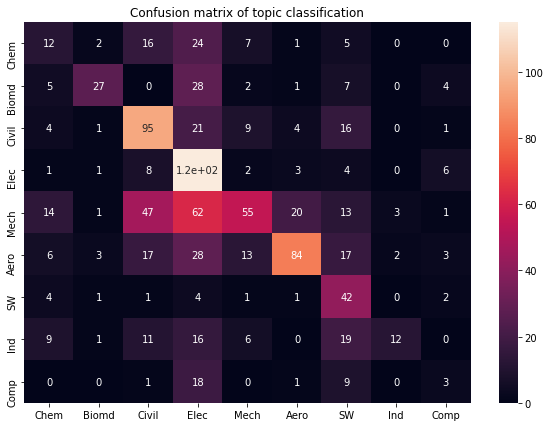

In [20]:
doc_utils.plotConfMatrix(y_test, predictions, model = "NN")

Recall that the test dataset was :

* 32 articles from category topic 'Computer engineering'[TopicID:8]
* 56 articles from category topic 'Software engineering'[TopicID:6]
* 67 articles from category topic 'Chemical engineering'[TopicID:0]
* 74 articles from category topic 'Industrial engineering'[TopicID:7]
* 73 articles from category topic 'Biomedical engineering'[TopicID:1]
* 140 articles from category topic 'Electrical engineering'[TopicID:3]
* 151 articles from category topic 'Civil engineering'[TopicID:2]
* 173 articles from category topic 'Aerospace engineering'[TopicID:5]
* 216 articles from category topic 'Mechanical engineering'[TopicID:4]

##Using full content from test dataset pages

### Obtaining average performance
Note: running 30 trials takes around 2 minutes.

In [21]:
n_runs = 30
mean_acc = 0
max_acc = 0

acc_list = []

print("Executing",n_runs,"runs of model training/evaluation...\n")

for i in tqdm(range(n_runs)):
    clear_session()

    #Neural Architecture Definition
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(len(dict_f),)))

    model.add(Dense(len(doc_utils.ALL_TOPICS), activation='softmax'))
    #Model compilation
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
    #Model training
    hist = model.fit(x_train_f, y_train_f, epochs=5,verbose=0)

    model_acc = model.evaluate(x_test_f, y_test_f, verbose=0)[1]
    acc_list.append(model_acc)

    if model_acc >= max(acc_list):
        #save best model to date
        model_json = model.to_json()
        with open("model_f.json", "w") as f:
            f.write(model_json)
        model.save_weights("model_f.h5")


print("\nResulting Average accuracy:",np.mean(acc_list))
print("Best accuracy:", max(acc_list))

Executing 30 runs of model training/evaluation...





Resulting Average accuracy: 0.34262461852283543
Best accuracy: 0.4333672431522141


### Visualizing (single) model classification performance (C.Matrix)

In [22]:
#loading best model obtained
json_f = open('model_f.json', 'r')
best_model_f_json = json_f.read()
json_f.close()
best_model_f = model_from_json(best_model_f_json)
#loading weights
best_model_f.load_weights("model_f.h5")

# evaluate loaded model on test data
best_model_f.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
predictions_f = best_model_f.predict_classes(x_test_f) #for later building confusion matrix
print("Model accuracy:",best_model_f.evaluate(x_test_f, y_test_f, verbose=0)[1])

Model accuracy: 0.4333672431522141


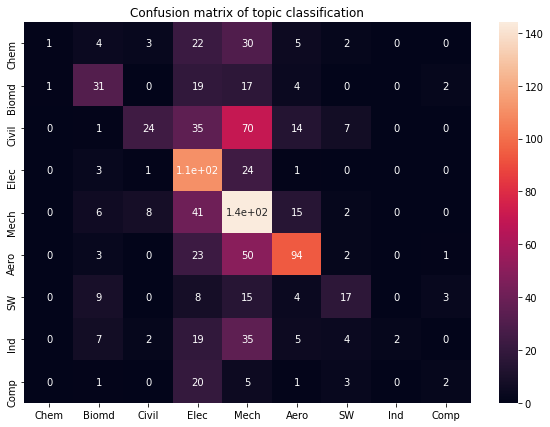

In [23]:
doc_utils.plotConfMatrix(y_test_f, predictions_f, model="NN")

It is interesting to look how now it has obtained better results on some classes but worse on others.

Recall that the test dataset was :

* 32 articles from category topic 'Computer engineering'[TopicID:8]
* 56 articles from category topic 'Software engineering'[TopicID:6]
* 67 articles from category topic 'Chemical engineering'[TopicID:0]
* 74 articles from category topic 'Industrial engineering'[TopicID:7]
* 73 articles from category topic 'Biomedical engineering'[TopicID:1]
* 140 articles from category topic 'Electrical engineering'[TopicID:3]
* 151 articles from category topic 'Civil engineering'[TopicID:2]
* 173 articles from category topic 'Aerospace engineering'[TopicID:5]
* 216 articles from category topic 'Mechanical engineering'[TopicID:4]

#Support Vector Machine Test

Uses a different data processing pipeline: TF-IDF

In [7]:
topic_defs = doc_utils.concurrentGetWikiFullPage(topics_list = doc_utils.ALL_TOPICS)

test_raw_data, total_num_articles = doc_utils.concurrentGetAllCatArticles(doc_utils.ALL_TOPICS, full_text_test=True)

Obtaining full wikipedia page for the topic: Chemical engineering. (Definition of Class #[0])
Obtaining full wikipedia page for the topic: Biomedical engineering. (Definition of Class #[1])
Obtaining full wikipedia page for the topic: Civil engineering. (Definition of Class #[2])Obtaining full wikipedia page for the topic: Electrical engineering. (Definition of Class #[3])

Obtaining full wikipedia page for the topic: Mechanical engineering. (Definition of Class #[4])
Obtaining full wikipedia page for the topic: Aerospace engineering. (Definition of Class #[5])
Obtaining full wikipedia page for the topic: Software engineering. (Definition of Class #[6])
Obtaining full wikipedia page for the topic: Industrial engineering. (Definition of Class #[7])
Obtaining full wikipedia page for the topic: Computer engineering. (Definition of Class #[8])
Retrieved 32 articles from category topic 'Computer engineering'[TopicID:8]
Retrieved 56 articles from category topic 'Software engineering'[TopicID

In [0]:
x_train, y_train, x_test, y_test = doc_utils.processClassifierData(topic_defs, test_raw_data)

In [10]:
n_runs = 30
mean_acc = 0
max_acc = 0

acc_list = []
best_svm = None

print("Executing",n_runs,"runs of SVM classifiers...")

for i in tqdm(range(n_runs)):

    text_clf_svm = Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),
                            ('clf-svm', SGDClassifier()),
                            ])    

    _ = text_clf_svm.fit(x_train, y_train)

    predicted_svm = text_clf_svm.predict(x_test)
    classification_accuracy = np.mean(predicted_svm == y_test)

    acc_list.append(classification_accuracy)
    
    if classification_accuracy >= max(acc_list):
        best_svm = text_clf_svm

print("Resulting Average accuracy:",np.mean(acc_list))
print("Best accuracy:", max(acc_list))

Executing 30 runs of SVM classifiers...



Resulting Average accuracy: 0.2985757884028485
Best accuracy: 0.5228891149542217


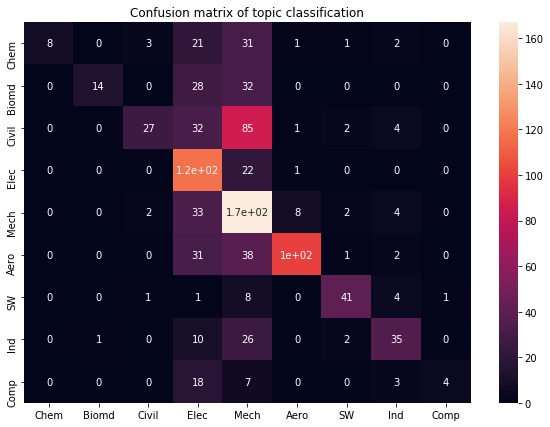

In [12]:
svm_predictions = best_svm.predict(x_test)

doc_utils.plotConfMatrix(y_test, svm_predictions, model="SVM")

# Multinomial Naive Bayes Test

In [0]:
x_train, y_train, x_test, y_test = doc_utils.processClassifierData(topic_defs, test_raw_data)

In [9]:
n_runs = 30
mean_acc = 0
max_acc = 0

acc_list = []
best_NB = None

print("Executing",n_runs,"runs of Multinomial NaiveBayes classifiers...")

for i in tqdm(range(n_runs)):

    text_clf_NB = Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),
                            ('clf-NB', MultinomialNB()),
                            ])    

    _ = text_clf_NB.fit(x_train, y_train)

    predicted_NB = text_clf_NB.predict(x_test)
    classification_accuracy = np.mean(predicted_NB == y_test)

    acc_list.append(classification_accuracy)
    
    if classification_accuracy >= max(acc_list):
        best_NB = text_clf_NB

print("Resulting Average accuracy:",np.mean(acc_list))
print("Best accuracy:", max(acc_list))

Executing 30 runs of Multinomial NaiveBayes classifiers...



Resulting Average accuracy: 0.5920651068158698
Best accuracy: 0.5920651068158698


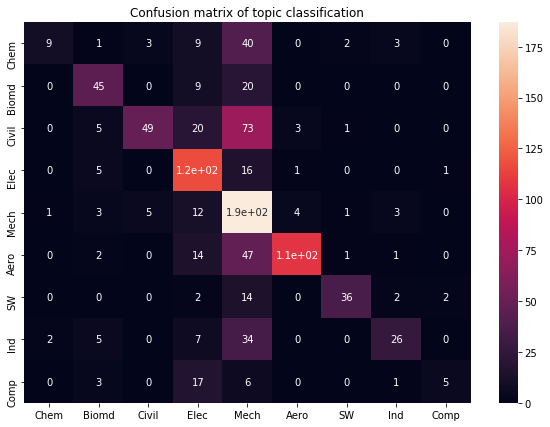

In [11]:
NB_predictions = best_NB.predict(x_test)

#This one has "preference" towards Mech. engineering. Curious
doc_utils.plotConfMatrix(y_test, NB_predictions, model="NB")